# Efficient Storage

In [1]:
import os
import random
import pretty_midi

def get_random_midi_file(root_dir):
    midi_files = []
    for dirpath, _, filenames in os.walk(root_dir):
        for filename in filenames:

            if filename.endswith('.mid') or filename.endswith('.midi'):
                midi_files.append(os.path.join(dirpath, filename))
    
    if not midi_files:
        raise FileNotFoundError(f"No MIDI files found in {root_dir}")
    
    return random.choice(midi_files)

# Usage
root_directory = './lmd_full'
random_midi_file = get_random_midi_file(root_directory)
print(f"Random MIDI file: {random_midi_file}")

filename = random_midi_file

def get_random_pretty_midi_file():
    filename = get_random_midi_file(root_directory)
    return pretty_midi.PrettyMIDI(filename)

Random MIDI file: ./lmd_full/6/60f4f7f37aa4dae34d541673cfc956ff.mid


In [2]:
import torch
def process_midi_data(midi_data):
    song = []
    time_per_quarter_note = midi_data.tick_to_time(midi_data.resolution)
    for i, instrument in enumerate(midi_data.instruments):
        for note in instrument.notes:
            track = i
            start = note.start
            duration = note.end - note.start
            pitch = note.pitch

            notedata = [track, start, duration, pitch]
            song.append(notedata)
        # sort by start time
        song.sort(key=lambda x: x[1])
        # prepend the time_per_quarter_note
    song.insert(0, [time_per_quarter_note, 0, 0, 0])
    return torch.tensor(song, dtype=torch.float32)

song_lengths = []
songs = []
for i in range(100):
    try:
        midi_data = get_random_pretty_midi_file()
    except Exception as e:
        print(f"Error reading file: {e}")
        continue

    song = process_midi_data(midi_data)
    songs.append(song)

def get_memory_used(tensor):
    return tensor.element_size() * tensor.nelement()

total_memory = 0
for song in songs:
    total_memory += get_memory_used(song)

print(f"Total memory used: {total_memory} bytes")
# in MB
print(f"Total memory used: {total_memory / 1024 / 1024} MB")

/home/diegocaples/miniconda3/envs/ai/lib/python3.12/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Error reading file: data byte must be in range 0..127
Error reading file: data byte must be in range 0..127
Total memory used: 5545296 bytes
Total memory used: 5.2884063720703125 MB


# Loading Data (old)

In [3]:

        

def process_midi(filename, track_index=0):
    # Load the MIDI file
    midi_data = pretty_midi.PrettyMIDI(filename)

    # Print the TPQN (Ticks Per Quarter Note)
    print("TPQN:", midi_data.resolution)

    # Print the time per tick
    time_per_tick = midi_data.tick_to_time(1)
    print("Time per tick:", time_per_tick)

    # Get the specified track of the MIDI file
    track = midi_data.instruments[track_index]

    # Get all the "note on" messages in the track
    note_on_messages = [note for note in track.notes if note.velocity > 0]

    # Assuming 4/4 time signature
    ticks_per_measure = 4 * midi_data.resolution

    # Create a list to store the annotated notes
    annotated_notes = []

    # Iterate over each note on message
    for i, note in enumerate(note_on_messages):
        # Get the measure index of the note
        tick = midi_data.time_to_tick(note.start)
        measure_index = tick // ticks_per_measure

        # Get the ticks since the last measure for the note
        ticks_since_last_measure = tick % ticks_per_measure

        # Get the ticks since the last note
        if i > 0:
            ticks_since_last_note = tick - midi_data.time_to_tick(note_on_messages[i-1].start)
        else:
            ticks_since_last_note = tick

        # Create a dictionary to store the annotated note information
        annotated_note = {
            'note': note,
            'measure_index': measure_index,
            'ticks_since_last_measure': ticks_since_last_measure,
            'ticks_since_last_note': ticks_since_last_note
        }

        # Append the annotated note to the list
        annotated_notes.append(annotated_note)

    # Print the first 10 annotated notes
    # for i, annotated_note in enumerate(annotated_notes[:10]):
    #     print("Note:", annotated_note['note'])
    #     print("Measure Index:", annotated_note['measure_index'])
    #     print("Ticks since last measure:", annotated_note['ticks_since_last_measure'])
    #     print("Ticks since last note:", annotated_note['ticks_since_last_note'])
    #     print("---")

    return annotated_notes

# Usage
filename = random_midi_file
track_index = 0

annotated_notes = process_midi(filename, track_index)
print(len(annotated_notes))

TPQN: 96
Time per tick: 0.005208333333333333
12


In [4]:
import torch
import pretty_midi

# class for a song

class Song:
    def __init__(self, filename):
        midi_data = pretty_midi.PrettyMIDI(filename)
        self.time_per_measure = midi_data.tick_to_time(midi_data.resolution * 4)
        self.tracks = []
        for track in midi_data.instruments:
            track_data = []
            for note in track.notes:
                start_tick = note.start
                pitch = note.pitch
                track_data.append([start_tick, pitch])
            # add the track data to the list of tracks in a torch tensor
            self.tracks.append(torch.tensor(track_data, dtype=torch.float32))

In [5]:
def process_midi_file(filename):
    try:
        song = Song(filename)
        return song, None
    except Exception as e:
        return None, e

def collect_midi_files(root_directory):
    midi_files = []
    for dirpath, _, filenames in os.walk(root_directory):
        for filename in filenames:
            if filename.endswith('.mid') or filename.endswith('.midi'):
                midi_files.append(os.path.join(dirpath, filename))
    return midi_files

if __name__ == "__main__":
    root_directory = './lmd_full'
    midi_files = collect_midi_files(root_directory)

    songs = []
    errors_processing = 0

    with Pool(cpu_count()) as pool:
        results = list(tqdm(pool.imap(process_midi_file, midi_files), total=len(midi_files)))

    for song, error in results:
        if song:
            songs.append(song)
        if error:
            errors_processing += 1

    print(f"Errors processing: {errors_processing}")


NameError: name 'Pool' is not defined

In [ ]:
import pretty_midi
import os
root_directory = './lmd_full'
midi_files = []
for dirpath, _, filenames in os.walk(root_directory):
    for filename in filenames:

        if filename.endswith('.mid') or filename.endswith('.midi'):
            midi_files.append(
                os.path.join(dirpath, filename)
            )

songs_to_count = 100
print(f"Total number of MIDI files: {len(midi_files)}")
errors_processing = 0
total_number_of_notes = 0
for i, midi_data in enumerate(midi_files):
    try:
        # get the total number of notes
        notes_per_song = 0
        midi_file = pretty_midi.PrettyMIDI(midi_data)
        for track in midi_file.instruments:
            notes_per_song += len(track.notes)
        # print(f"notes per song: {notes_per_song}")
        total_number_of_notes += notes_per_song
    except Exception as e:
        print(e)
        errors_processing += 1
    if i > songs_to_count:
        break

    
print(f"Total number of notes: {total_number_of_notes}")
notes_per_file = total_number_of_notes / songs_to_count
print(f"notes per file: {notes_per_file}")

Total number of MIDI files: 178561
MThd not found. Probably not a MIDI file


/home/diegocaples/miniconda3/envs/ai/lib/python3.12/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Total number of notes: 380165
notes per file: 3801.65


In [ ]:
from tqdm import tqdm

songs = []
errors_processing = 0
for midi_data in tqdm(midi_files):
    try:
        song = Song(midi_data)
        songs.append(song)
    except Exception as e:
        errors_processing += 1

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset

class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = {'data': self.data[idx], 'label': self.labels[idx]}
        return sample

# Generate some random data
data = torch.randn(100, 3, 32, 32)  # 100 samples, 3 channels, 32x32 images
labels = torch.randint(0, 10, (100,))  # 100 labels for 10 classes

# Create dataset and dataloader
dataset = MyDataset(data, labels)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2)

# Iterate through the dataloader
for batch in dataloader:
    data_batch = batch['data']
    labels_batch = batch['label']
    print(data_batch.shape, labels_batch.shape)
    # Add your training code here


torch.Size([4, 3, 32, 32]) torch.Size([4])
torch.Size([4, 3, 32, 32]) torch.Size([4])
torch.Size([4, 3, 32, 32]) torch.Size([4])
torch.Size([4, 3, 32, 32]) torch.Size([4])
torch.Size([4, 3, 32, 32]) torch.Size([4])
torch.Size([4, 3, 32, 32]) torch.Size([4])
torch.Size([4, 3, 32, 32]) torch.Size([4])
torch.Size([4, 3, 32, 32]) torch.Size([4])
torch.Size([4, 3, 32, 32]) torch.Size([4])
torch.Size([4, 3, 32, 32]) torch.Size([4])
torch.Size([4, 3, 32, 32]) torch.Size([4])
torch.Size([4, 3, 32, 32]) torch.Size([4])
torch.Size([4, 3, 32, 32]) torch.Size([4])
torch.Size([4, 3, 32, 32]) torch.Size([4])
torch.Size([4, 3, 32, 32]) torch.Size([4])
torch.Size([4, 3, 32, 32]) torch.Size([4])
torch.Size([4, 3, 32, 32]) torch.Size([4])
torch.Size([4, 3, 32, 32]) torch.Size([4])
torch.Size([4, 3, 32, 32]) torch.Size([4])
torch.Size([4, 3, 32, 32]) torch.Size([4])
torch.Size([4, 3, 32, 32]) torch.Size([4])
torch.Size([4, 3, 32, 32]) torch.Size([4])
torch.Size([4, 3, 32, 32]) torch.Size([4])
torch.Size(

In [ ]:


class SongData(Dataset):
    def __init__(self, songs):
        self.songs = songs
        self.global_track_id_to_song_id = []
        for i, song in enumerate(songs):
            for track in song.instruments:
                self.global_track_id_to_song_id.append(i)

    def __len__(self):
        return len(self.global_track_id_to_song_id)

    def __getitem__(self, instance_idx):  
        song_idx = self.global_track_id_to_song_id[instance_idx]
        song = self.songs[song_idx]
        track_idx = instance_idx - song_idx
        sample = {'data': self.data[idx], 'label': self.labels[idx]}
        return sample

# Generate some random data
data = torch.randn(100, 3, 32, 32)  # 100 samples, 3 channels, 32x32 images
labels = torch.randint(0, 10, (100,))  # 100 labels for 10 classes

# Create dataset and dataloader
dataset = MyDataset(data, labels)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2)

# Iterate through the dataloader
for batch in dataloader:
    data_batch = batch['data']
    labels_batch = batch['label']
    print(data_batch.shape, labels_batch.shape)
    # Add your training code here



In [ ]:
import sys
from collections import deque

def get_recursive_size(obj, seen=None):
    """Recursively finds the total memory usage of an object."""
    if seen is None:
        seen = set()
    
    obj_id = id(obj)
    
    if obj_id in seen:
        return 0
    
    seen.add(obj_id)
    
    size = sys.getsizeof(obj)
    
    if isinstance(obj, dict):
        size += sum(get_recursive_size(v, seen) for v in obj.values())
        size += sum(get_recursive_size(k, seen) for k in obj.keys())
    elif hasattr(obj, '__dict__'):
        size += get_recursive_size(obj.__dict__, seen)
    elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
        size += sum(get_recursive_size(i, seen) for i in obj)
    
    return size

# Example usage
example_object = [1, 2, {3: "a", 4: ["b", "c"]}]
object_1 = [([1.1]*500) for _ in range(1000)]
object_2 = [torch.tensor([1.1]*500) for _ in range(1000)]

print("python")
print(get_recursive_size(object_1))
print("tensors")
print(get_recursive_size(object_2))

# # get the number of instruments
# midi_data.instruments


4972757
TPQN: 384
Time per tick: 0.0015625
103823


[Instrument(program=57, is_drum=False, name="Melodie 4"),
 Instrument(program=42, is_drum=False, name="Violoncl2"),
 Instrument(program=24, is_drum=False, name="GuitarAc3"),
 Instrument(program=24, is_drum=False, name="GuitarAc5")]

# Preprocessing All Data into sequences

In [1]:
# Get a list of all the filenames
import os
import random
import pretty_midi

def get_all_filenames(root_dir):
    midi_files = []
    for dirpath, _, filenames in os.walk(root_dir):
        for filename in filenames:

            if filename.endswith('.mid') or filename.endswith('.midi'):
                midi_files.append(os.path.join(dirpath, filename))
    
    if not midi_files:
        raise FileNotFoundError(f"No MIDI files found in {root_dir}")
    return midi_files

# Usage
root_directory = './lmd_full'
files = get_all_filenames(root_directory)

In [2]:
import torch
import pretty_midi
def process_midi_data(midi_filename):
    try:
        midi_data = pretty_midi.PrettyMIDI(midi_filename)
    except Exception as e:
        return None, e
    song = []
    time_per_quarter_note = midi_data.tick_to_time(midi_data.resolution)
    for i, instrument in enumerate(midi_data.instruments):
        for note in instrument.notes:
            track = i
            start = note.start
            duration = note.end - note.start
            pitch = note.pitch

            notedata = [track, start, duration, pitch]
            song.append(notedata)
        # sort by start time
        song.sort(key=lambda x: x[1])
        # prepend the time_per_quarter_note
    song.insert(0, [time_per_quarter_note, 0, 0, 0])
    return torch.tensor(song, dtype=torch.float32), None

# Usage
filename = random.choice(files)
song, error = process_midi_data(filename)
print(f"Filename: {filename}")

# the reuslting format:
# header: [time_per_quarter_note, 0, 0, 0]
# each note: [track, start, duration, pitch]

print(f"first note:")
print(f"track: {song[1][0]}")
print(f"start: {song[1][1]}")
print(f"duration: {song[1][2]}")
print(f"pitch: {song[1][3]}")

print(f"\nsecond note:")
print(f"track: {song[2][0]}")
print(f"start: {song[2][1]}")
print(f"duration: {song[2][2]}")
print(f"pitch: {song[2][3]}")


Filename: ./lmd_full/6/659414fa1c3016d94d997128f528a73b.mid
first note:
track: 2.0
start: 3.2987499237060547
duration: 3.619999885559082
pitch: 60.0

second note:
track: 2.0
start: 3.2987499237060547
duration: 3.640000104904175
pitch: 72.0


In [3]:
# simple example of loading all the files (single process)
errors = []
songs = []
totalsongs = len(files)
for i, file in enumerate(files):
    if i % 1000 == 0:
        print(f"{i/totalsongs:.2f}% complete ({i})")
    try:
        song, error = process_midi_data(file)
        if error is not None:
            errors.append(error)
            continue
        songs.append(song)
    except Exception as e:
        print(f"unusual error: {e}")
    # if i > 100:
    #     break

0.00% complete (0)


/home/diegocaples/miniconda3/envs/ai/lib/python3.12/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


0.01% complete (1000)
0.01% complete (2000)
0.02% complete (3000)
0.02% complete (4000)
0.03% complete (5000)
0.03% complete (6000)
0.04% complete (7000)
0.04% complete (8000)
0.05% complete (9000)
0.06% complete (10000)
0.06% complete (11000)
0.07% complete (12000)
0.07% complete (13000)
0.08% complete (14000)
0.08% complete (15000)
0.09% complete (16000)
0.10% complete (17000)
0.10% complete (18000)
0.11% complete (19000)
0.11% complete (20000)
0.12% complete (21000)
0.12% complete (22000)
0.13% complete (23000)
0.13% complete (24000)
unusual error: index -16307 is out of bounds for axis 0 with size 14508
0.14% complete (25000)
0.15% complete (26000)
0.15% complete (27000)
0.16% complete (28000)
0.16% complete (29000)
0.17% complete (30000)
0.17% complete (31000)
0.18% complete (32000)
0.18% complete (33000)
0.19% complete (34000)
0.20% complete (35000)
0.20% complete (36000)
0.21% complete (37000)
0.21% complete (38000)
0.22% complete (39000)
0.22% complete (40000)
0.23% complete (4

In [8]:
# Number of groups to split into
num_groups = 10

# Calculate the size of each group
group_size = len(songs) // num_groups

# Save each group directly
for i in range(num_groups):
    start_idx = i * group_size
    end_idx = (i + 1) * group_size if i < num_groups - 1 else len(songs)
    torch.save(songs[start_idx:end_idx], f'./dataset/song_group_{i}.pth')

# Handle any remaining tensors if the list size isn't perfectly divisible
if len(songs) % num_groups != 0:
    torch.save(songs[num_groups * group_size:], f'./dataset/song_group_{num_groups - 1}.pth')

# Training Hacking

In [1]:
# import torch

# loading all the data
# loaded_song_groups = []
# for i in range(num_groups):
#     loaded_song_groups.append(torch.load(f'./dataset/song_group_{i}.pth'))

# # Optionally, you can concatenate all groups back into a single list if needed
# loaded_songs = [song for group in loaded_song_groups for song in group]


In [2]:
import torch

# Load the first group of tensors
first_group = torch.load('./dataset/song_group_0.pth')

In [3]:
# the reuslting format:
# header: [time_per_quarter_note, 0, 0, 0]
# each note: [track, start, duration, pitch]

first_group[4]

tensor([[ 0.7059,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  1.4118,  0.1765, 43.0000],
        [ 0.0000,  1.4118,  1.0588, 55.0000],
        ...,
        [ 0.0000, 57.9706,  2.6471, 50.0000],
        [ 0.0000, 58.0147,  2.6471, 55.0000],
        [ 0.0000, 58.0588,  2.6471, 59.0000]])

this is how the dataset building would work on a mock dataset

In [4]:
test_context_length = 3

a = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
b = [11, 12, 13, 14, 15, 16, 17, 18]

dataset = [a, b]

# desired datastructure:
# index 1: song [0], notes 0-2
# index 2: song [0], notes 2-4
# index 3: song [0], notes 4-6
# index 4: song [0], notes 6-8
# index 5: song [0], notes 8-9
# index 6: song [1], notes 0-2
# ...

# stored in the format: [song_index, note_start_index]

# Create the dataset
train_idxs = []
for i, song in enumerate(dataset):
    for j in range(0, len(song), test_context_length):
        train_idxs.append([i, j])



test_context_length = 3

a = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
b = [11, 12, 13, 14, 15, 16, 17, 18]

dataset = [a, b]

# desired datastructure:
# index 1: song [0], notes 0-2
# index 2: song [0], notes 2-4
# index 3: song [0], notes 4-6
# index 4: song [0], notes 6-8
# index 5: song [0], notes 8-9
# index 6: song [1], notes 0-2
# ...

# stored in the format: [song_index, note_start_index]

# Create the dataset
data = []
for i, song in enumerate(dataset):
    for j in range(len(song) - test_context_length):
        if j % test_context_length == 0:
            data.append([i, j])


def build_idxs(dataset, context_length, ignore_header=True):
    idxs = []
    if ignore_header:
        start_idx = 1
    else:
        start_idx = 0
    for i, song in enumerate(dataset):
        for j in range(start_idx, len(song) - context_length, context_length):
            idxs.append([i, j])
    return idxs

# Usage
test_context_length = 3
dataset = [a, b]
train_idxs = build_idxs(dataset, test_context_length)

song, note_start = train_idxs[0]
dataset[song][note_start:note_start + test_context_length]

[2, 3, 4]

In [5]:
# dataset is the first_group, but remove the first element of each song
# first element is the header
# each song is a tensor
dataset = []
for song in first_group:
    dataset.append(song)


context_length = 128

dataset_idxs = build_idxs(dataset, context_length)

song, note_start = dataset_idxs[1]

In [66]:
import torch
from torch.utils.data import Dataset, DataLoader

class SongDataSet(Dataset):
    def __init__(self, songs, context_length=128, quantize_divisor=64):
        self.songs = songs
        self.dataset_idxs = build_idxs(songs, context_length)
        self.quantize_divisor = quantize_divisor
        self.perturbation_std = 0.05
        self.context_length = context_length

    def __len__(self):
        return len(self.dataset_idxs)

    def __getitem__(self, idx, different_perturbation_std=False):
        song_idx, note_start_idx = self.dataset_idxs[idx]
        song = self.songs[song_idx]
        notes = song[note_start_idx:note_start_idx + context_length]
        # Note format: [track, start, duration, pitch]

        time_per_quarter_note = song[0][0] # header, first element
        time_per_tick = (time_per_quarter_note * 4 / self.quantize_divisor).item() # quantize_divisor is ticks per measure

        perturbed_notes = notes.clone()
        # add gausian perturbations to start duration, note index 1 and 2
        # return torch.normal(0, self.perturbation_std, perturbed_notes[:, 1].shape).shape
        perturbation_std = self.perturbation_std
        if different_perturbation_std is not False:
            perturbation_std = different_perturbation_std
        perturbed_notes[:, 1] += torch.normal(0, self.perturbation_std, perturbed_notes[:, 1].shape)
        perturbed_notes[:, 2] += torch.normal(0, self.perturbation_std, perturbed_notes[:, 2].shape)
        
        
        perturbed_notes_quantized = self.quantize_notes(perturbed_notes, time_per_tick)

        notes_quantized = self.quantize_notes(notes, time_per_tick)

        return {"notes": notes_quantized, "perturbed_notes": perturbed_notes_quantized, "time_per_tick": time_per_tick}
        


    def quantize_notes(self, notes, time_per_tick):
        # subtract the start time of the note with the smallest start time from all notes (zero-based start times, even if first is negative or positive)
        min_start_time = notes[:, 1].min()
        notes[:, 1] -= min_start_time

        quantized_notes = []
        for note in notes:
            quantized_note = self.quantize_note(note, time_per_tick)
            quantized_notes.append(quantized_note) # quantizes to about 3/100 of a second (depending on the song's time signature)
        
        while len(quantized_notes) < self.context_length:
            quantized_notes.append(torch.tensor([99999, 99999, 99999, 99999], dtype=torch.int32))
        return torch.stack(quantized_notes)
    
        

    def quantize_note(self, note, time_per_tick):
        track, start, duration, pitch = note

        track = track.item()
        start = start.item()
        duration = duration.item()
        pitch = pitch.item()

        start = round(start / time_per_tick)
        duration = round(duration / time_per_tick)
        return torch.tensor([track, start, duration, pitch], dtype=torch.int32)


# Usage
song_dataset = SongDataSet(dataset, context_length=128)
song_dataset[1]
# # Create a DataLoader
# dataloader = DataLoader(song_dataset, batch_size=1, shuffle=True)
# for batch in dataloader:
#     print(batch)
#     break

{'notes': tensor([[  1,   0,  16,  69],
         [  2,   0,  16,  50],
         [  3,   0,  16,  38],
         [  5,   0,  16,  66],
         [  0,  16,  16,  76],
         [  1,  16,  16,  72],
         [  2,  16,  16,  48],
         [  3,  16,  16,  36],
         [  5,  16,  16,  67],
         [  0,  32,  16,  74],
         [  1,  32,  16,  71],
         [  2,  32,  16,  43],
         [  5,  32,  16,  67],
         [  0,  48,  32,  71],
         [  1,  48,  16,  67],
         [  2,  48,  32,  55],
         [  3,  48,  32,  43],
         [  5,  48,  16,  62],
         [  1,  64,  32,  67],
         [  5,  64,  32,  62],
         [  0,  80,  12,  71],
         [  2,  80,  16,  50],
         [  0,  92,   4,  69],
         [  0,  96,  12,  67],
         [  1,  96,  16,  64],
         [  2,  96,  16,  48],
         [  5,  96,  16,  60],
         [  0, 108,   4,  64],
         [  0, 112,  32,  67],
         [  1, 112,  16,  62],
         [  2, 112,  32,  55],
         [  3, 112,  32,  43],

## My Format Analysis and Music Demo

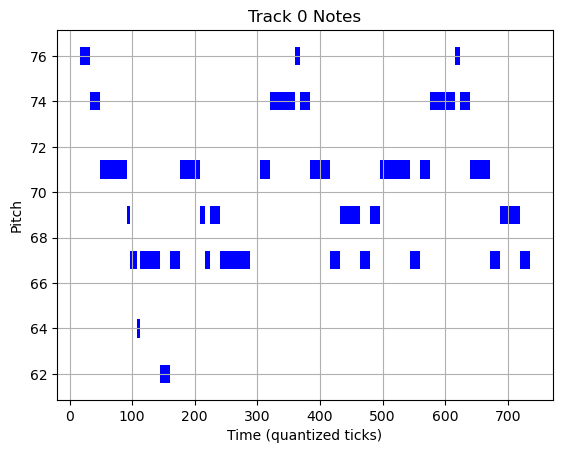

In [8]:
import matplotlib.pyplot as plt

def plot_track(song_tensor, track_number):
    """
    Plots the notes of a specific track from a song tensor.

    Parameters:
    - song_tensor: torch.Tensor, the quantized notes tensor of the song.
    - track_number: int, the track number to plot.
    """
    # Filter notes for the specified track
    track_notes = song_tensor[song_tensor[:, 0] == track_number]

    if track_notes.size(0) == 0:
        print(f"No notes found for track {track_number}")
        return

    # Extract start times, durations, and pitches
    start_times = track_notes[:, 1].numpy()
    durations = track_notes[:, 2].numpy()
    pitches = track_notes[:, 3].numpy()

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Plot each note as a horizontal bar
    for start, duration, pitch in zip(start_times, durations, pitches):
        ax.broken_barh([(start, duration)], (pitch - 0.4, 0.8), facecolors='blue')

    # Set labels and title
    ax.set_xlabel('Time (quantized ticks)')
    ax.set_ylabel('Pitch')
    ax.set_title(f'Track {track_number} Notes')

    # Show grid
    ax.grid(True)

    # Show the plot
    plt.show()

# Example usage
# Assuming song_dataset is an instance of SongDataSet and song_tensor is a tensor from the dataset
song_tensor = song_dataset[1]  # Get the first song tensor
plot_track(song_tensor, track_number=0)  # Plot the first track

In [ ]:
import matplotlib.pyplot as plt

def plot_all_tracks(song_tensor):
    """
    Plots the notes of all tracks from a song tensor, each in its own subplot.

    Parameters:
    - song_tensor: torch.Tensor, the quantized notes tensor of the song.
    """
    # Get unique track numbers
    track_numbers = song_tensor[:, 0].unique().numpy()

    # Create a figure with subplots
    fig, axes = plt.subplots(len(track_numbers), 1, figsize=(10, 5 * len(track_numbers)), sharex=True)

    if len(track_numbers) == 1:
        axes = [axes]  # Ensure axes is iterable if there's only one track

    # Plot each track
    for ax, track_number in zip(axes, track_numbers):
        # Filter notes for the current track
        track_notes = song_tensor[song_tensor[:, 0] == track_number]

        if track_notes.size(0) == 0:
            continue

        # Extract start times, durations, and pitches
        start_times = track_notes[:, 1].numpy()
        durations = track_notes[:, 2].numpy()
        pitches = track_notes[:, 3].numpy()

        # Plot each note as a horizontal bar
        for start, duration, pitch in zip(start_times, durations, pitches):
            ax.broken_barh([(start, duration)], (pitch - 0.4, 0.8), facecolors='blue')

        # Set labels and title
        ax.set_ylabel('Pitch')
        ax.set_title(f'Track {track_number} Notes')
        ax.grid(True)

    # Set common x-label
    axes[-1].set_xlabel('Time (quantized ticks)')

    # Show the plot
    plt.tight_layout()
    plt.show()

# Example usage
# Assuming song_dataset is an instance of SongDataSet and song_tensor is a tensor from the dataset
song_tensor = song_dataset[1]  # Get the first song tensor
plot_all_tracks(song_tensor)  # Plot all tracks

In [69]:
import pretty_midi
import torch

def tensor_to_midi(tensor, output_filename, time_per_tick):
    """
    Converts a tensor representation of a song back to a MIDI file.

    Parameters:
    - tensor: torch.Tensor, the quantized notes tensor of the song.
    - output_filename: str, the filename for the output MIDI file.
    """
    # Create a PrettyMIDI object
    midi = pretty_midi.PrettyMIDI()

    # Get unique track numbers
    track_numbers = tensor[:, 0].unique().numpy()

    for track_number in track_numbers:
        # Create an Instrument instance for each track
        instrument = pretty_midi.Instrument(program=0)  # Default to Acoustic Grand Piano

        # Filter notes for the current track
        track_notes = tensor[tensor[:, 0] == track_number]

        # Extract start times, durations, and pitches
        start_times = track_notes[:, 1].numpy()
        durations = track_notes[:, 2].numpy()
        pitches = track_notes[:, 3].numpy()

        # Create Note objects and add them to the instrument
        for start, duration, pitch in zip(start_times, durations, pitches):
            note = pretty_midi.Note(
                velocity=100,  # Default velocity
                pitch=int(pitch),
                start=(start*time_per_tick).item(),
                end=((start + duration)*time_per_tick).item()
            )
            instrument.notes.append(note)

        # Add the instrument to the PrettyMIDI object
        midi.instruments.append(instrument)

    # Write out the MIDI data
    midi.write(output_filename)

# Example usage




song_example = song_dataset[1]  # Get the first song tensor
notes = song_example["notes"]
perturbed_notes = song_example["perturbed_notes"]
time_per_tick = song_example["time_per_tick"]

tensor_to_midi(perturbed_notes, 'output_song.mid', time_per_tick)

In [70]:
import pygame

def play_midi_file(midi_filename):
    """
    Plays a MIDI file using pygame.

    Parameters:
    - midi_filename: str, the filename of the MIDI file to play.
    """
    # Initialize pygame
    pygame.init()

    # Set up the mixer to play MIDI
    pygame.mixer.init()
    pygame.mixer.music.load(midi_filename)

    # Play the MIDI file
    pygame.mixer.music.play()

    # Keep the program running until the music stops
    while pygame.mixer.music.get_busy():
        pygame.time.Clock().tick(10)

# Example usage
midi_filename = 'output_song.mid'
play_midi_file(midi_filename)

## Building the Model

In [72]:
import os 

device= 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_default_device(device)
assert device == 'cuda', "This notebook is not optimized for CPU"

config = {
    "learning_rate": 1e-3,
    "eval_interval": 300,
    "max_iters": 3000, 
    "H": 16,
    "B": 64,
    "T": 128,
    "C": 256,
    "feedforward_factor": 3,
    "n_heads": 6,
    "dropout": 0.4,
    "l2_penalty": 0.0,
    "n_layers": 6,
    "tokenizer_vocab_size": 4096,
    "git_hash": os.popen("git rev-parse HEAD").read().strip()
}

# initial
for k,v in config.items():
    locals ()[k] = v

In [73]:

import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)


class Head(nn.Module):
    '''One Head of self-attention'''
    def __init__(self, H):
        super().__init__()
        self.query = nn.Linear(C, H, bias=False)
        self.key = nn.Linear(C, H, bias=False)
        self.value = nn.Linear(C, H, bias=False)
        # self.output = nn.Linear(H, C, bias=False) # output matrix
        self.register_buffer('tril', torch.tril(torch.ones(T, T)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Query and Key matrices for the attention mechanism
        # x: 8 tokens
        # Q: 16 tall (arbitrary), 32 long channels
        # K: 16 tall (arbitrary), 32 long channels

        query_vectors = self.query(x)
        key_vectors = self.key(x)


        # Attention masking(so we can't look into the past):

        tril = self.tril
        wei = torch.zeros(T, T) 
        wei = wei.masked_fill(tril == 0, float('-inf')) # set the upper triangular to -inf
        # xbow = wei @ x # apply the mask to the input, bag of words because simple avg.

        # multiply the two to get the attention weights
        attention_pattern = query_vectors @ key_vectors.transpose(-2, -1) # T, T
        attention_pattern = attention_pattern / (H ** 0.5) # scale the attention pattern for numerical stability
        attention_weights = F.softmax(attention_pattern + wei, dim=-1) # T, T (the row dimension is the query)
        attention_weights = self.dropout(attention_weights)

        value_vectors = self.value(x) # the direction we should go in the embedding space for each token (ie more blue) T, H

        # apply the attention weights to the value vectors
        context = attention_weights @ value_vectors # T, H

        # project back into original space from value space
        # return self.output(context)
        return context

x = torch.randn(B,T,C)
head = Head(H)
# head(x)